Root Mean Squared Error (RMSE) on Validation Data: 0.1458

Top 10 Important Features:
          Feature  Importance
3     OverallQual    0.377851
36        TotalSF    0.376870
5       YearBuilt    0.016507
15      GrLivArea    0.014083
25     GarageCars    0.013851
6    YearRemodAdd    0.012517
2         LotArea    0.012194
26     GarageArea    0.010829
229  CentralAir_Y    0.009815
8      BsmtFinSF1    0.009612


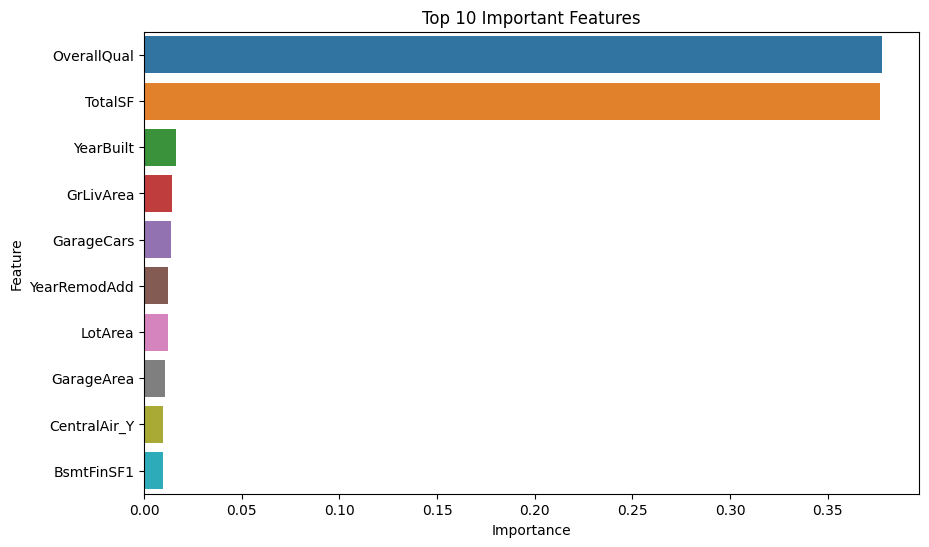

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Extract the target variable
y = train_data['SalePrice']

# Combine train and test data for preprocessing
all_data = pd.concat([train_data.drop(columns=['SalePrice']), test_data], axis=0)

# Data Preprocessing

# Log-transform the target variable (SalePrice)
y = np.log1p(y)

# Drop the 'Id' column as it doesn't provide useful information
all_data.drop(columns=['Id'], inplace=True)

# Handle missing values
missing_cols = all_data.columns[all_data.isnull().any()]

# Impute missing values based on data description (you may need to customize this)
for col in missing_cols:
    if all_data[col].dtype == 'object':
        all_data[col].fillna('None', inplace=True)
    else:
        all_data[col].fillna(0, inplace=True)

# Feature engineering (you may need to customize this)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Handle skewed features by applying log transformation
numeric_cols = all_data.select_dtypes(exclude=['object']).columns
skewed_cols = all_data[numeric_cols].apply(lambda x: skew(x.dropna()))
skewed_cols = skewed_cols[skewed_cols > 0.75].index
all_data[skewed_cols] = np.log1p(all_data[skewed_cols])

# One-hot encoding for categorical variables
all_data = pd.get_dummies(all_data)

# Split the data back into train and test sets
X = all_data[:len(train_data)]
X_test = all_data[len(train_data):]

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f'Root Mean Squared Error (RMSE) on Validation Data: {rmse:.4f}')

# Feature Importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print('\nTop 10 Important Features:')
print(feature_importance.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.xlabel('Importance')
plt.title('Top 10 Important Features')
plt.show()

# Train the model on the entire training data
rf_model.fit(X, y)

# Make predictions on the test set
y_test_pred = rf_model.predict(X_test)

# Transform the predictions back to the original scale
y_test_pred = np.expm1(y_test_pred)

# Prepare the submission file
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)
